In [1]:
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from lib.functions import LogisticRegression
import lib.load_datasets as load_datasets
from lib.compressions import *
from lib.gradient_descent import *
from functools import partial

In [2]:
X, y = load_datasets.dataset_to_X_y('diabetes.csv', normalize=True, nrows=500)
# X, y = make_blobs(n_samples=500, centers=2, n_features=5, random_state=0)
function = LogisticRegression(X, y)
dim = function.getDimention()
alpha = 0.0001 # for diabetes
# alpha = 0.04 # for make_blobs
print(dim)

9


In [9]:
base_experiments = [
    compressedGD(function, name='Without', compressor=Compressor(topK, k=dim), alpha=0.0001),
    #compressedGD(function, name='Top-k, k=d/3', compressor=Compressor(topK, k=dim//3), alpha=alpha),
    compressedGD(function, name='Top-k, k=d/2', compressor=Compressor(topK, k=dim//2), alpha=alpha),
    #compressedGD(function, name='Top-k, k=1', compressor=Compressor(topK, k=1), alpha=alpha),
    compressedGD(function, name='Rand-k, k=d/3', compressor=Compressor(uniformCompression, k=dim//3), alpha=alpha),
    #compressedGD(function, name='Rand-k, k=1', compressor=Compressor(uniformCompression, k=1), alpha=alpha),
    stochasticCompressedGD(function, name='Ban 2 in a row, k=d/3', compressor=SmartCompressor(ban2InARow, k=dim//3), alpha=alpha),
    stochasticCompressedGD(function, name='Reduce probability, k=d/3, penalty=0.5', compressor=SmartCompressor(partial(reduceProbability, penalty=0.5), k=dim//3), alpha=alpha),
]

In [10]:
new_experiments = [
    stochasticCompressedGD(function, name='With penalty, k=d/3, step=0.333', compressor=SmartCompressor(partial(compressionWithPenalty, step=0.333), k=dim//3), alpha=alpha),
    stochasticCompressedGD(function, name='New reduce probability, k=d/3, penalty=0.5', compressor=SmartCompressor(partial(newReduceProbability, penalty=0.5), k=dim//3), alpha=alpha),
]

In [11]:
adaptive_experiments = [
    adaptiveCompressedGD(function, name='topUnknown, beta=1', compressor=AdaptiveCompressor(partial(topUnknown, beta=1)), alpha=alpha),
]

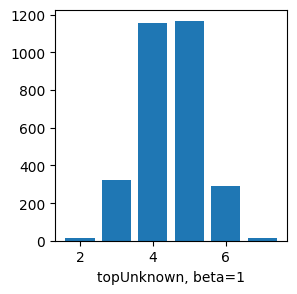

In [12]:
plt.figure(figsize=(3, 3))

dictionary = adaptive_experiments[0]['k_distribution']
plt.bar(list(dictionary.keys()), dictionary.values())
plt.xlabel(adaptive_experiments[0]['name'])

#fig, axs = plt.subplots(1, len(adaptive_experiments), tight_layout=True)
#for i, exp in enumerate(adaptive_experiments):
#    dictionary = exp['k_distribution']
#    axs[i].bar(list(dictionary.keys()), dictionary.values())
#    axs[i].set_title(exp['name'].split()[-1])

plt.show()

In [13]:
experiments = base_experiments + new_experiments + adaptive_experiments
experiments.sort(key=lambda exp : exp['coords'][-1])

table = [
    ["compression", "num_iter", "transmitted coordinates"],
    *[
        [exp['name'], exp['num_iter'], exp['coords'][-1]]
        for exp in experiments
    ]
]
print(tabulate(table))

------------------------------------------  --------  -----------------------
compression                                 num_iter  transmitted coordinates
Top-k, k=d/2                                3321      13284
topUnknown, beta=1                          2965      13294
Reduce probability, k=d/3, penalty=0.5      4608      13824
Ban 2 in a row, k=d/3                       5366      16098
With penalty, k=d/3, step=0.333             5403      16209
New reduce probability, k=d/3, penalty=0.5  5730      17190
Rand-k, k=d/3                               6859      20577
Without                                     2309      20781
------------------------------------------  --------  -----------------------


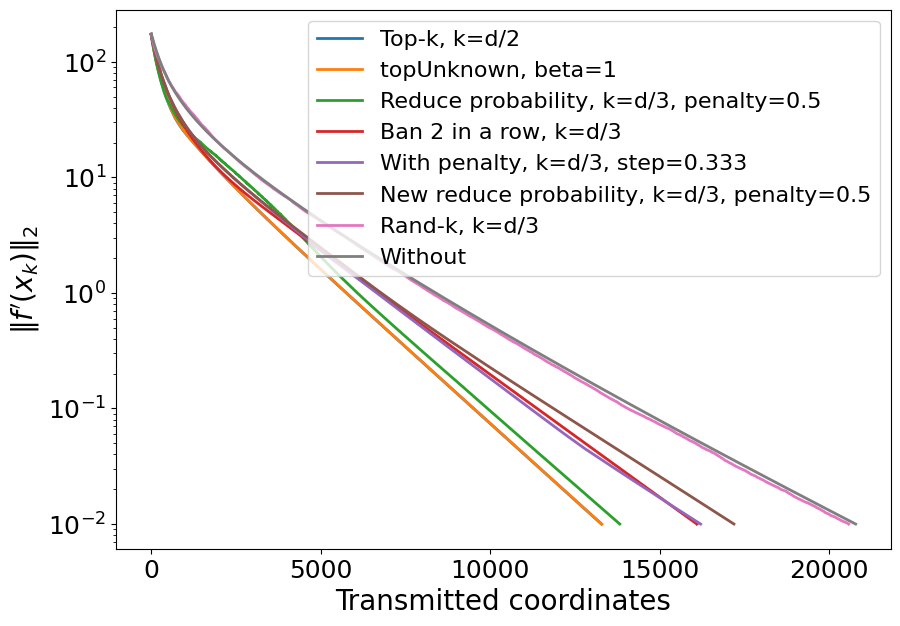

In [14]:
plt.figure(figsize=(10, 7))
for exp in experiments:
    plt.semilogy(
        exp['coords'],
        [grad_norm for grad_norm in exp['gradients']],
        label=exp['name'],
        linewidth=2
    )
plt.legend(loc="best", fontsize=16)
plt.xlabel(r"Transmitted coordinates", fontsize=20)
plt.ylabel(r"$\|f'(x_k)\|_2$", fontsize=20)
plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)